In this Notebook we further cluster 1023 communities to 100 communities.

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import h5py
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image
import sklearn.cluster
import scipy.cluster.hierarchy as sch

sys.path.append(
    os.path.abspath(
        os.path.join("__file__", '..', '..')
    )
)

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.cm as cm
from env.env_setup import second_cluster_logger
from util.notebook_util import get_epi_analysis, compute_eff_rep_num_sec_clu

## Environment Settings

In [4]:
# number of clusters in the second clustering
n_clusters = second_cluster_logger['n_cluster']
recovery_day = second_cluster_logger['recovery_day']

## File Settings

In [5]:
###################
##### File settings
###################
# result directory
res_dir = os.path.abspath(
    os.path.join(os.path.curdir, '..', 'results')
)

# figure directory
fig_dir = os.path.abspath(
    os.path.join(os.path.curdir, '..', 'figures')
)

# epidemiology result file
epi_resfile = os.path.join(
    res_dir, 'epi_analysis.hdf5'
)

# reproduction numbers
base_path = os.path.join(os.path.abspath(os.path.join("__file__", '..', '..','results')))
save_file_name = 'rep_num_exp.pkl'
save_str = os.path.abspath(os.path.join(base_path, 
                                            save_file_name))   

#### Load clustering file

In [6]:
# open result file from clustering 
complevel=7
complib='zlib'
key_base = Path("/first_clustering")
with pd.HDFStore(epi_resfile, complevel=complevel, complib=complib) as store:
    print(f"File {epi_resfile} has {len(store.keys())} entries.")

    ########################################################
    ##### Load clustering and the corresponding csse results
    ########################################################
    # cluster information
    key = str(key_base / 'basic' / "cluster")
    df_clusters = store[key]

    # confirmed cases information
    key = str(key_base / 'basic' / "confirmed_cases")
    df_confirmed_case = store[key]

    #############################
    ##### population related data
    #############################
    # suspected population
    key = str(key_base / "population" / "suspected_population")
    df_sus_population = store[key]

    # suspected portion
    key = str(key_base / "population" / "suspected_portion")
    df_sus_portion = store[key] 

    # infected population
    key = str(key_base / "population" / "infected_population")
    df_inf_population = store[key] 

    # infected portion
    key = str(key_base / "population" / "infected_portion")
    df_inf_portion = store[key]

##########################
##### Reproduction numbers
##########################
with open(save_str, 'rb') as f:
    rep_num_logger = pickle.load(f)

# basic reproduction number matrix
basic_rep_num_mat = rep_num_logger["basic_reproduction_number_matrix"]

# effective reproduction number matrix
eff_rep_num_list = rep_num_logger["effective_reproduction_number_matrix"]

File /home/python/shared/results/epi_analysis.hdf5 has 12 entries.


In [7]:
df_clusters

,leaves,X,Y,population
0,746,-65.794825,18.277415,390728.0
1,458,-66.083320,18.131576,488287.0
2,873,-66.079340,18.396328,1011530.0
3,8,-66.344566,18.363775,425126.0
4,641,-66.582628,18.044742,354598.0
...,...,...,...,...
1018,911,-158.026269,21.423245,459209.0
1019,7,-157.813184,21.329035,529047.0
1020,392,-156.517054,20.867763,161290.0
1021,808,-155.865732,19.692965,88670.0


## Community map before clustering

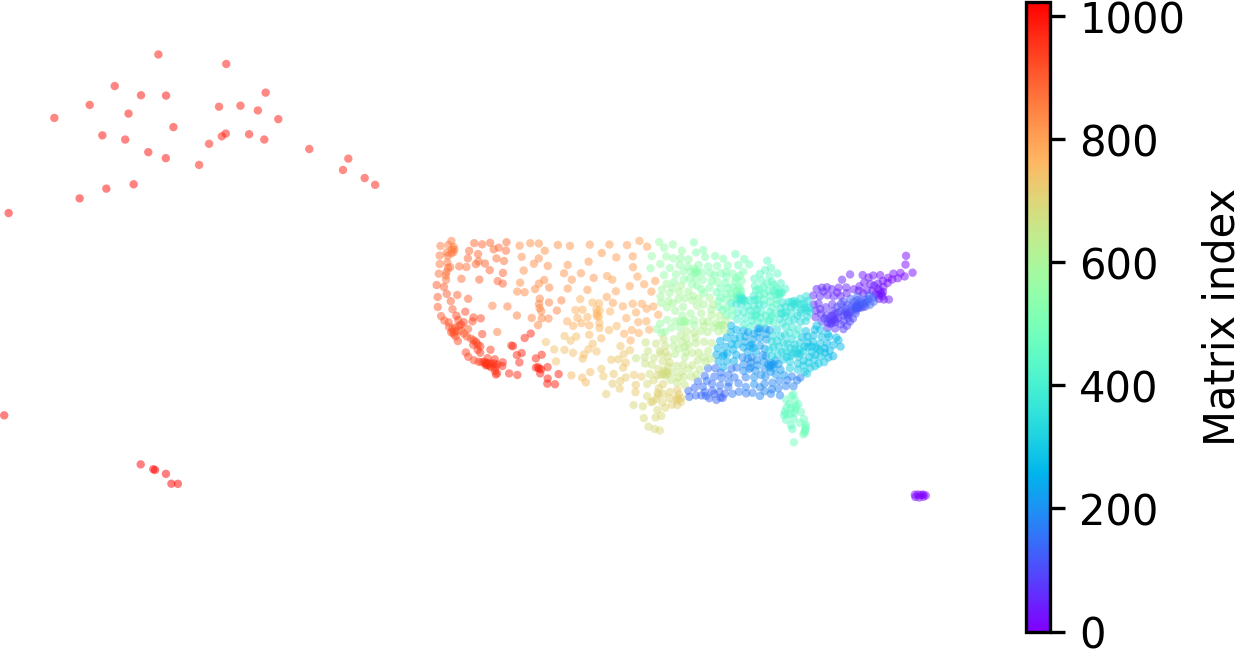

In [8]:
fname = 'clusters_after_ordering'
filepath = os.path.join(fig_dir , (fname + '.png'))
Image(filename=filepath, width=4./3*360)

## Second Clustering

#### K-means clustering -- KMeans()

In [9]:
# Get the latitude and longitude
XY = np.array([[x[1],x[2]] for x in df_clusters.to_numpy()])

# do clustering
np.random.seed(111)

clustering = sklearn.cluster.KMeans(n_clusters = n_clusters, algorithm="full")
res = clustering.fit(XY)

# get cluster center
cluster_centers = res.cluster_centers_
data_labels = res.predict(XY)
data_labels = pd.DataFrame(data_labels, index=df_clusters.index)
data_labels.rename(columns={0: 'leaves'}, inplace=True)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [10]:
data_labels

,leaves
0,8
1,8
2,8
3,8
4,8
...,...
1018,75
1019,75
1020,75
1021,6


#### Re-order clusters using a hierarchichal clustering method

In [11]:
XY = cluster_centers.copy()
Z = sch.linkage(XY, method='average')
Z = sch.optimal_leaf_ordering(Z, XY)
leaves = sch.leaves_list(Z).astype('int64')


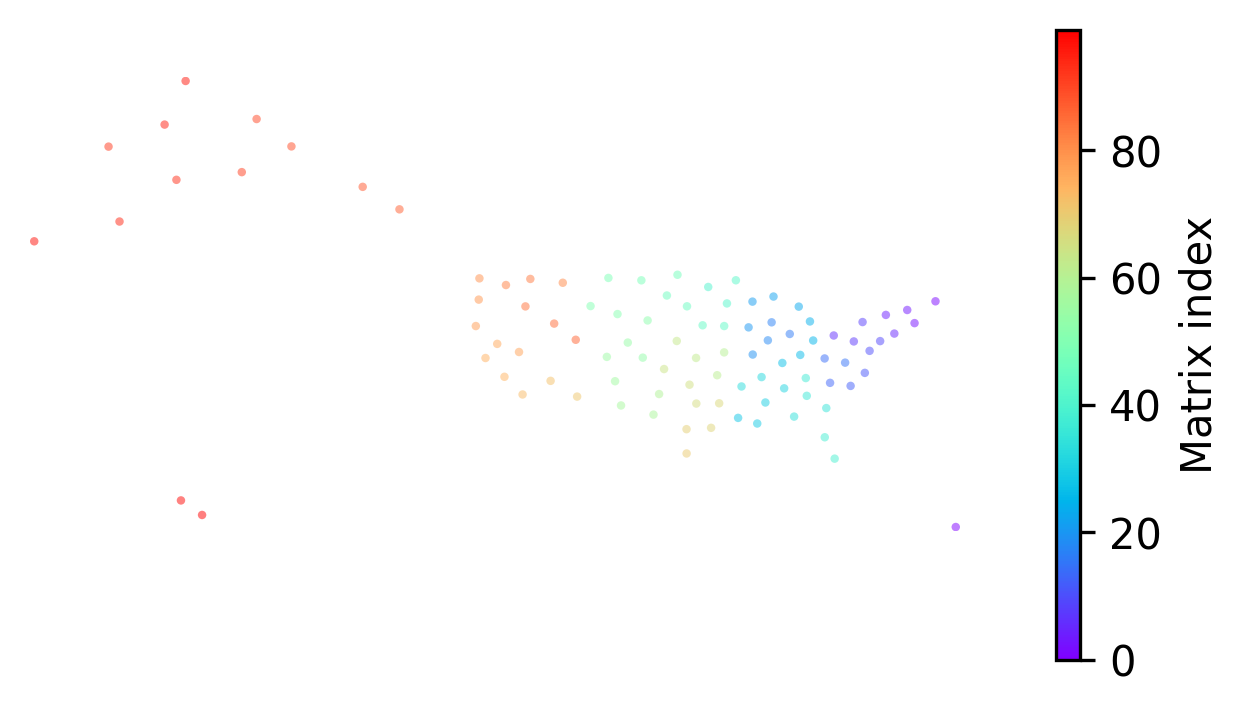

In [12]:
cluster_centers_ordered = cluster_centers[leaves]
X,Y = cluster_centers_ordered.T
npts = len(X)
indices = np.arange(npts)

norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = cm.rainbow

colors = cmap(norm(indices))

fig = plt.figure(figsize=(4,3),dpi=300)
ax = fig.gca()
for i in np.arange(npts):
#     if i % idump == 0:
#         print(f"{i} / {npts}")
    x = X[i]
    y = Y[i]
    circle = plt.Circle((x,y), 0.5, color=colors[i], alpha=0.5, lw=0)
    ax.add_patch(circle)
    
xmin = np.min(X) - 0.5
xmax = np.max(X) + 0.5
ymin = np.min(Y) - 0.5
ymax = np.max(Y) + 0.5
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
for lab in 'left', 'right', 'bottom', 'top':
    ax.spines[lab].set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
cax = fig.add_axes(rect=[0.98,0.1,0.02,0.7])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, label='Matrix index', extendfrac='auto')

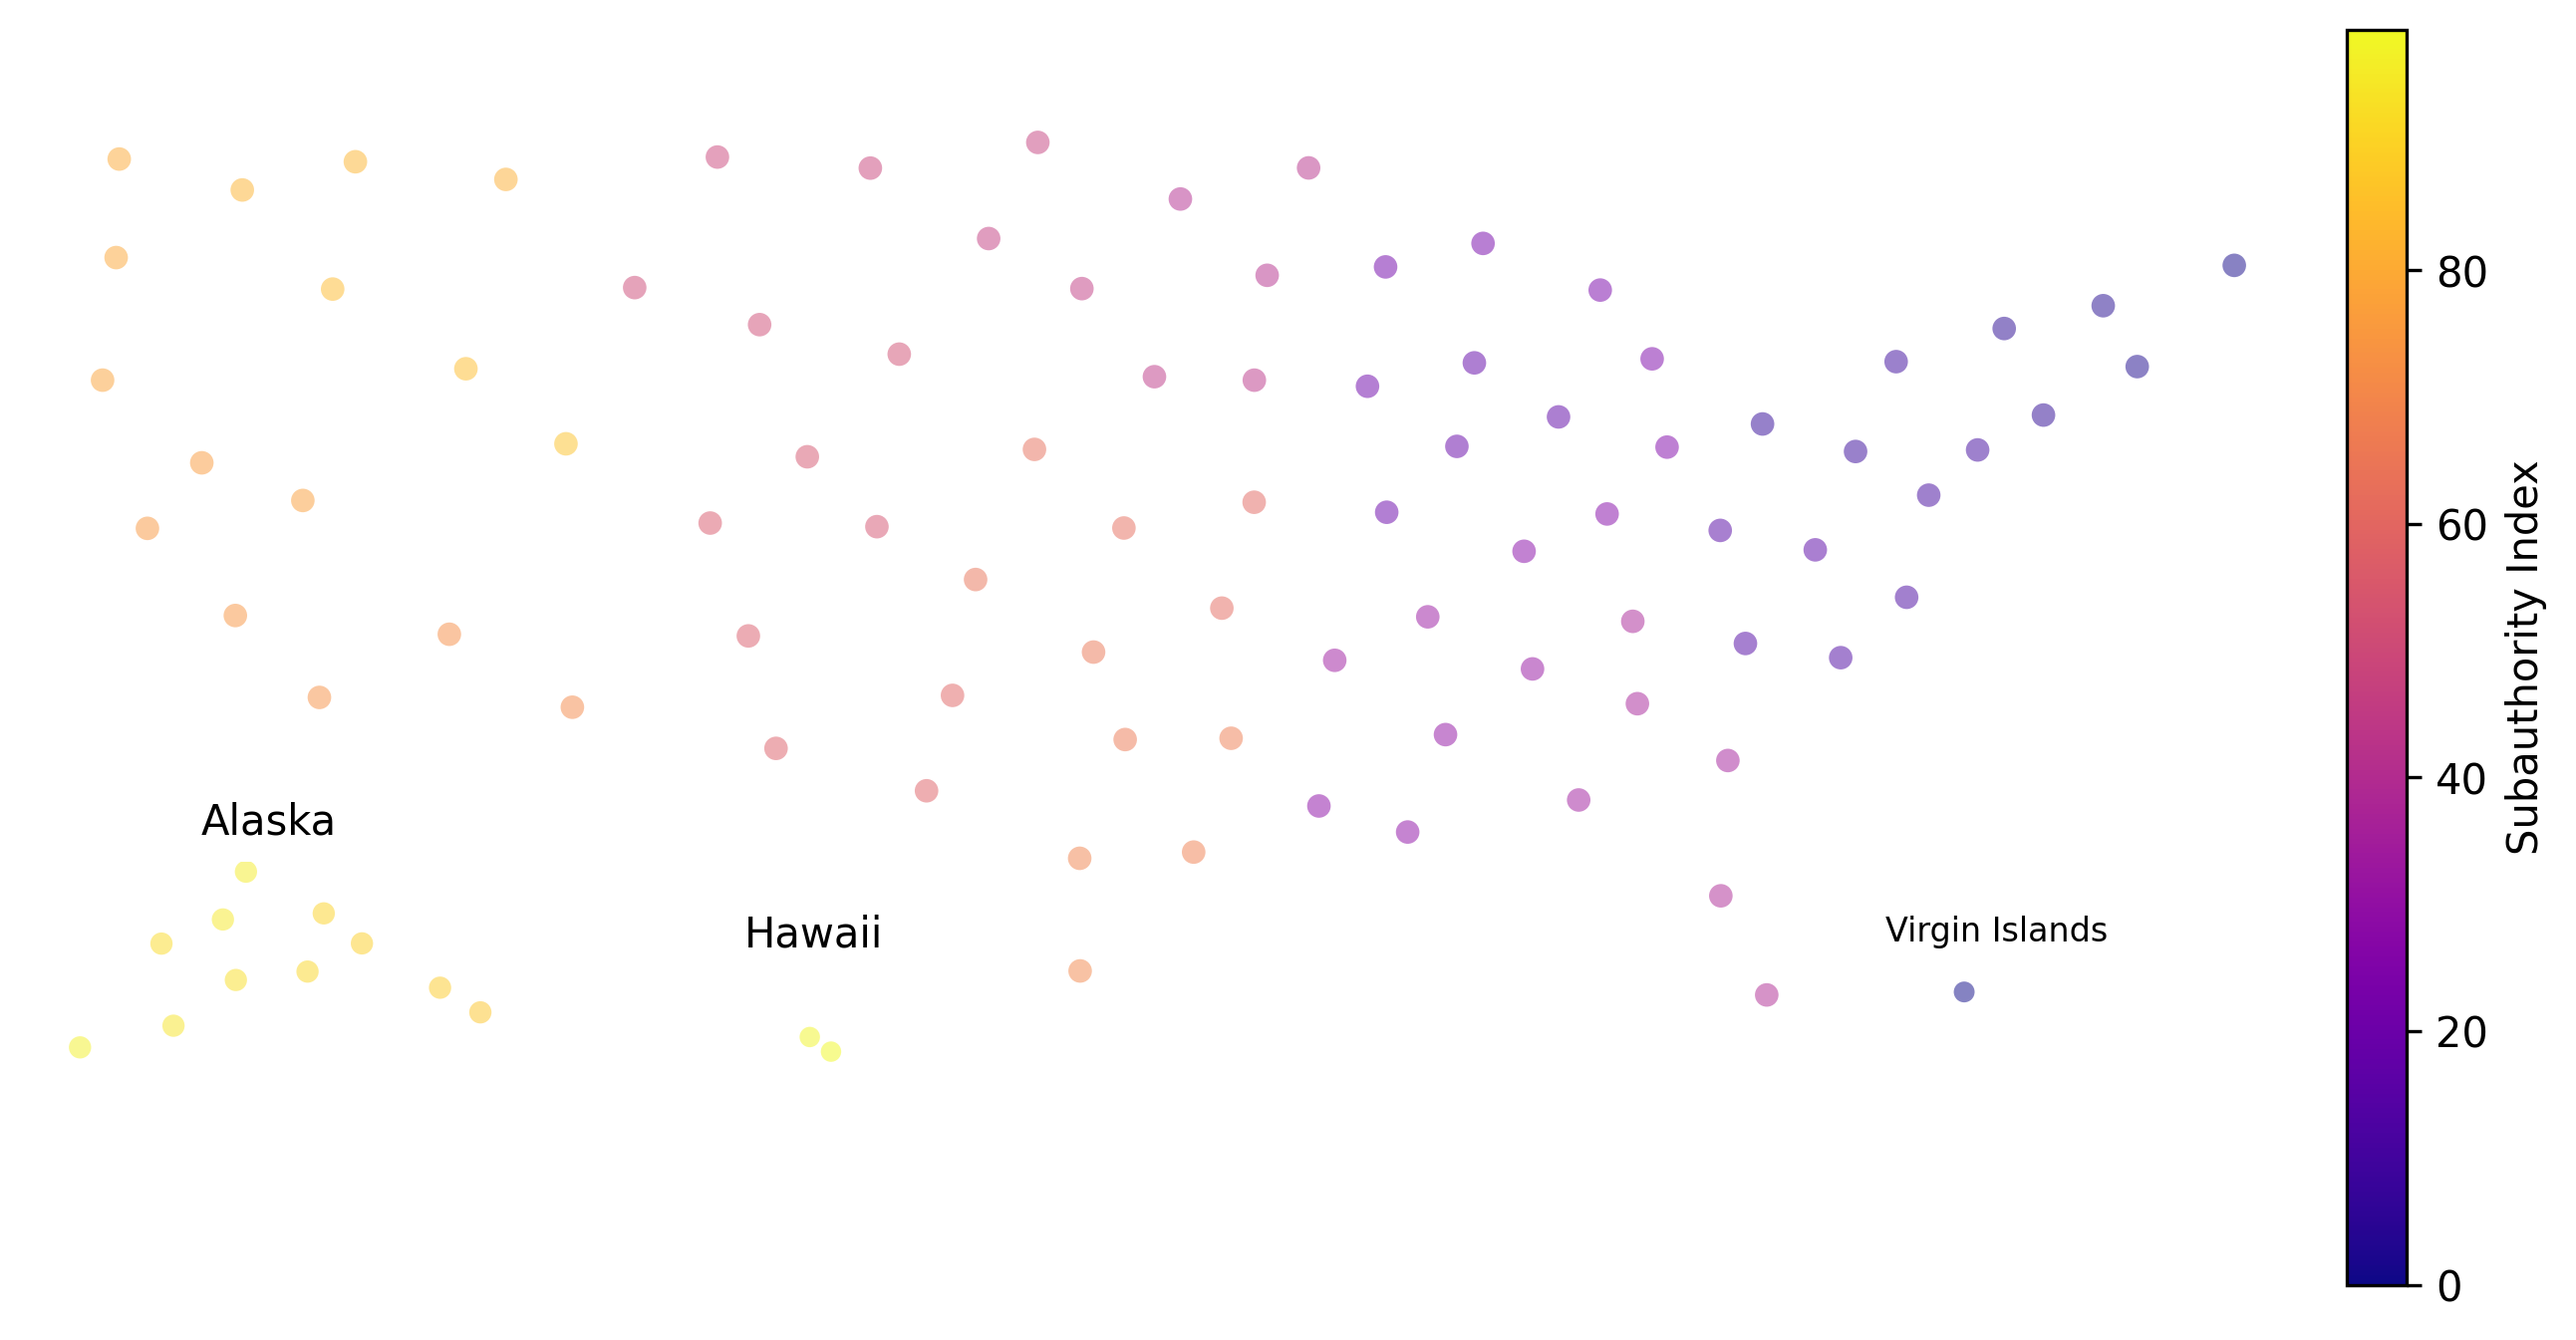

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mco
import scipy.cluster.hierarchy as sch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

# Assuming Z and cluster_centers are already defined
# Load ordered leaves
leaves = sch.leaves_list(Z).astype('int64')

# Get the cluster centers associated with each leaf
cluster_centers_ordered = cluster_centers[leaves]

# Get the latitude and longitude
X, Y = cluster_centers_ordered.T

npts = len(X)

# Normalize colors based on the number of points
indices = np.arange(npts)
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = plt.colormaps['plasma']

# Get color maps
colors = cmap(norm(indices))

# Create the main figure and axis for the contiguous United States
fig, ax_main = plt.subplots(figsize=(10, 6), dpi=300)

# Set boundaries for the main map
xmin, xmax = -125, -66  # Rough boundaries for the contiguous US
ymin, ymax = 24, 50

ax_main.set_xlim(xmin, xmax)
ax_main.set_ylim(ymin, ymax)
ax_main.set_aspect('equal')

# Plot circles for the contiguous United States
circle_size = 0.3
for i in np.arange(npts):
    x, y = X[i], Y[i]
    # Skip points that belong to Alaska, Hawaii, or Virgin Islands (adjust based on coordinates)
    if x < -130 or (y < 20 and x > -125):
        continue
    # Draw a circle for each cluster
    circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
    ax_main.add_patch(circle)

# Add insets for Alaska, Hawaii, and Virgin Islands
# Use 4-tuple for bbox_to_anchor: (x0, y0, width, height)
ax_inset_ak = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0, 0, 0.2, 0.2), bbox_transform=ax_main.transAxes)


ax_inset_hi = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0.2, 0, 0.2, 0.1), bbox_transform=ax_main.transAxes)
ax_inset_vi = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0.78, 0, 0.15, 0.15), bbox_transform=ax_main.transAxes)

# Alaska plot
ax_inset_ak.set_xlim(-177, -130)
ax_inset_ak.set_ylim(50, 72)
ax_inset_ak.set_aspect('equal')

# Plot circles for Alaska
circle_size = 1.2
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -177 <= x <= -130 and 50 <= y <= 72:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_ak.add_patch(circle)

ax_inset_ak.text(-155, 75, 'Alaska', fontsize=10, ha='center')

# Hawaii plot
ax_inset_hi.set_xlim(-177, -154)
ax_inset_hi.set_ylim(18, 30)
ax_inset_hi.set_aspect('equal')

# Plot circles for Hawaii
circle_size = 1.2
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -177 <= x <= -154 and 18 <= y <= 30:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_hi.add_patch(circle)

# Add label for Hawaii
ax_inset_hi.text(-157.5, 32, 'Hawaii', fontsize=10, ha='center')

# Virgin Islands plot
ax_inset_vi.set_xlim(-68, -63)  # More zoomed-in x-limits for Virgin Islands
ax_inset_vi.set_ylim(17.6, 19)   # More zoomed-in y-limits for Virgin Islands
ax_inset_vi.set_aspect('equal')

# Plot circles for Virgin Islands
circle_size = 0.15
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -68 <= x <= -63 and 17.6 <= y <= 19:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_vi.add_patch(circle)

# Add label for Virgin Islands
ax_inset_vi.text(-66, 19, 'Virgin Islands', fontsize=8, ha='center')

# Remove axis spines and ticks
for ax in [ax_main, ax_inset_ak, ax_inset_hi, ax_inset_vi]:
    for lab in ['left', 'right', 'bottom', 'top']:
        ax.spines[lab].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Add color bar to the right side of the main figure
cax = fig.add_axes([0.9, 0.1, 0.02, 0.7])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Subauthority Index', extendfrac='auto')

# Show the plot
plt.show()

In [14]:
fname = 'clusters_after_second_clustering'
exts = ['.png', '.svg']
for ext in exts:
    filepath = os.path.join(fig_dir , (fname + ext))
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=300)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: /home/python/shared/figures/clusters_after_second_clustering.png
Written file: /home/python/shared/figures/clusters_after_second_clustering.svg


In [ ]:
fname = 'clusters_after_second_clustering'
filepath = os.path.join(fig_dir , (fname + '.png'))
Image(filename=filepath, width=4./3*360)

#### fill-in total population

In [ ]:
data_labels.leaves.max()

In [ ]:
# We first give maps the first cluster index to the second cluster index
groups = data_labels.groupby(["leaves"]).groups
groups = [groups[i].tolist() for i in range(len(cluster_centers))]
groups_ordered = [groups[leaves[i]] for i in range(len(leaves))]

df = pd.DataFrame(data=cluster_centers_ordered, columns=['X', 'Y'])
df = pd.concat([df, pd.DataFrame(pd.Series(groups_ordered), columns=['cbg_clusters'])], axis=1)
df = pd.concat([df, pd.DataFrame(pd.Series(leaves), columns=['leaves'])], axis=1)

df

In [ ]:
# fill-in population based on leaves index
data_labels['population'] = df_clusters["population"].loc[data_labels.index]
pop = data_labels.groupby(['leaves'])["population"].sum().to_frame()
pop

In [ ]:
# join the pop with df
df.reset_index(inplace=True)
df.set_index('leaves', inplace=True)
df.loc[pop.index,'population'] = pop['population']
df.reset_index(inplace=True)
df.set_index('index', inplace=True)
df

## Confirmed Cases for Each Cluster

In [ ]:
# Get confirmed case based on leaves index
df_confirmed_case_leaves = pd.DataFrame(data=df_confirmed_case)

# concatnate with leaves column
df_confirmed_case_leaves = pd.concat([df_confirmed_case_leaves, pd.DataFrame(data_labels, columns=['leaves'])], axis=1)
 
# Group by leaves and apply sum for each column
df_confirmed_case_leaves = df_confirmed_case_leaves.groupby("leaves").apply(sum)
del df_confirmed_case_leaves["leaves"]
df_confirmed_case_leaves

In [ ]:
# Check if any cluster has infected population greater than its population
idx = (df_confirmed_case_leaves.iloc[:, -1] > pop['population']).to_numpy()
np.sum(idx)

In [ ]:
df.sort_values('population', ascending=True)

In [ ]:
# map leaves to cluster_id
def leaves2clusterid(df_confirmed_case_leaves: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    """
    Map leaves id to cluster_id.

    Input:
        - df_confirmed_case_leaves: dataframe, daily confirmed cases with index as leaves_id.
        - df: dataframe, clusters info.

    Output:
        - df_confirmed_case: dataframe, daily confirmed cases with index as cluster_id
    """
    # create the map
    maps = dict()
    for i in range(len(df.index)):
        maps[df.loc[i]["leaves"]] = i

    # map the leaves id to cluster_id
    list_cluster_id = []
    for leaf in df_confirmed_case_leaves.index:
        list_cluster_id.append(maps[leaf])

    df_confirmed_case_leaves["cluster_id"] = list_cluster_id

    # sort index
    df_confirmed_case = df_confirmed_case_leaves.reset_index().set_index('cluster_id').sort_values("cluster_id")
    return df_confirmed_case

df_confirmed_case = leaves2clusterid(df_confirmed_case_leaves, df)
df_confirmed_case.iloc[:, 1:]

In [ ]:

df_sus_pop_sec_clu, df_sus_por_sec_clu, df_inf_pop_sec_clu, df_inf_por_sec_clu = get_epi_analysis(df_clusters = df[["leaves","X","Y","population"]], 
                                                                                        df_confirmed_case = df_confirmed_case.iloc[:, 1:],
                                                                                        recovery_day = recovery_day)

Let's do a little exploration: find the community that has the less suspected portion and check it variation over these days.

In [ ]:
final_day = df_sus_portion["04/20/21"]
sus_portion_min = final_day[final_day != 0].min()
final_day[final_day == sus_portion_min].index

In [ ]:
# The 951th community has the smallest suspected portion
df_sus_por_sec_clu.loc[92].plot()

Similarly, let's check the variation of infected portion of the 951th cluster.

In [ ]:
df_inf_por_sec_clu.loc[97].plot()

## Now we compute the effective reproduction number

In [ ]:
sus_portion_sec_clu = df_sus_pop_sec_clu.to_numpy()
inf_portion_sec_clu = df_inf_pop_sec_clu.to_numpy()
sus_portion_sec_clu.shape

In [ ]:
pd.set_option('display.max_rows', 500)
df_sus_pop_sec_clu.loc[97].reset_index()

In [ ]:
from collections import defaultdict

# create a map from first cluster_id to second cluster_id
firstClu2SecondClu = defaultdict(int)
for i in range(len(df.index)):
    cbg_clusters = df.loc[i]["cbg_clusters"]

    # create the map
    for first_clu_id in cbg_clusters:
        firstClu2SecondClu[first_clu_id] = i


res = compute_eff_rep_num_sec_clu(100, df_clusters["population"].to_numpy(), firstClu2SecondClu, df_inf_portion.to_numpy(), eff_rep_num_list)


In [ ]:
#### loop through eff_rep_num_list
community_97_eff_num = []
for i in range(len(res)):
    community_97_eff_num.append(res[i].eff_rep_num_mat[95][28])

plt.plot(community_97_eff_num[100:300])

## Write everything to file

In [ ]:
key_base = Path("/second_clustering")
with pd.HDFStore(epi_resfile, complevel=complevel, complib=complib) as store:
    ############################
    ##### basic information data
    ############################
    # cluster information
    key = str(key_base / "basic" / "cluster")
    store[key] = df

    # confirmed cases information
    key = str(key_base / "basic" / "confirmed_cases")
    store[key] = df_confirmed_case.iloc[:, 1:]

    #############################
    ##### population related data
    #############################
    # suspected population
    key = str(key_base / "population" / "suspected_population")
    store[key] = df_sus_pop_sec_clu

    # suspected portion
    key = str(key_base / "population" / "suspected_portion")
    store[key] = df_sus_por_sec_clu

    # infected population
    key = str(key_base / "population" / "infected_population")
    store[key] = df_inf_pop_sec_clu

    # infected portion
    key = str(key_base / "population" / "infected_portion")
    store[key] = df_inf_por_sec_clu

#################################
##### Reproduction number related
#################################
# effective reproduction number matrix
second_cluster_logger["effective_reproduction_number_matrix"] = res
second_cluster_logger["firstClu2SecondClu"] = firstClu2SecondClu

# save file
save_folder_str = os.path.join(os.path.abspath(os.path.join("__file__", '..', '..','results')))
save_file_name = second_cluster_logger['exp_name'] + 'test' + '.pkl'
save_str = os.path.abspath(os.path.join(save_folder_str, 
                                            save_file_name))   
with open(save_str, 'wb') as f:
    pickle.dump(second_cluster_logger, f, protocol=pickle.HIGHEST_PROTOCOL)